In [1]:
import pandas as pd
import numpy as np
from Bio import PDB
import concurrent
from tqdm.notebook import tqdm_notebook

from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils import *
from config import *

In [8]:
def extract_dna_coordinates(structure,):
    """
    Extract atomic coordinates based on chain type.
    chain_type can be 'protein' or 'dna'
    """
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if chain.id == 'C' or chain.id == 'D':
                    # The condition here assumes that DNA residues have different IDs from protein and water
                    for atom in residue:
                        coords.append(atom.coord)
    return coords

def minimum_distance(point, coords):
    """
    Calculate the minimum Euclidean distance between a point and a set of coordinates.
    """
    return min(((point - coord)**2).sum()**0.5 for coord in coords)

In [9]:
complex_pdb_file_path = f"{DATA}/in_complex.pdb" 

# Load PDB file
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("complex", complex_pdb_file_path)

# Extract atomic coordinates for protein and DNA
dna_coords = extract_dna_coordinates(structure)

# Determine residues at DNA interface
interface_residues = []
min_distance = []
threshold = 5.0  # Ångstroms

for model in structure:
    for chain in model:
        if chain.id != 'A':
            continue
        for residue in chain:
            d = 1e5
            if residue.id[0] == ' ':  # Only consider standard residues, not HETATM
                for atom in residue:
                    d_ = minimum_distance(atom.coord, dna_coords)
                    d = min(d, d_)
                min_distance.append(d)
                if d < threshold:
                    interface_residues.append(residue.id[1]-1102)

print(f"Residues at DNA interface: {interface_residues}")

Residues at DNA interface: [5, 9, 11, 12, 13, 14, 16, 33, 113, 117, 218, 219, 230, 231, 232, 233, 235, 238]


In [10]:
alascan_path = f"in_complex_AS.fxout"

critical_for_stability_residues = []
threshold = 1.  # kcal/mol
with open(alascan_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split()
        residue = parts[0]
        position = int(parts[1])
        energy_change = float(parts[-1])
        
        if energy_change > threshold:
            critical_for_stability_residues.append(position-1102)
critical_for_stability_residues = set(critical_for_stability_residues)

In [12]:
df = pd.read_excel(f"{DATA}/ML-designed PID.xlsx")

wt = df[df.batch == 0].iloc[0].seq

def mcherry_threshold(x):
    if x < 0.2:
        return 0
    if x < 0.5:
        return 1
    if x < 0.8:
        return 2
    return 3

batch = 2
colors = ["red", "darkorange", "gold", "green", "gray", "gray"]
batch_color = ["gray", "blue", "orange", "purple"]
batch_number = df[df.batch >= batch]["batch"].apply(lambda x: int(x)).values
functionality = df[df.batch >= batch]["mcherry"].apply(lambda x: colors[mcherry_threshold(x)]).values
functionality_number = df[df.batch >= batch]["mcherry"].apply(lambda x: mcherry_threshold(x)).values
sequences = list(df[df.batch >= batch].seq)

mutations = []
nb_mutations = []
nb_mutations_per_functionality = [[], [], [], []]
nb_mutations_at_interface = []
nb_mutations_at_interface_per_functionality = [[], [], [], []]
nb_mutations_at_stability = []
nb_mutations_at_stability_per_functionality = [[], [], [], []]
distance_mutations_at_interface = []
for functionality_number_, seq in zip(functionality_number, sequences):
    mutations.append(set([i for i in range(len(wt)) if wt[i] != seq[i]]))
    nb_mutations.append(len(mutations[-1]))
    nb_mutations_at_interface.append(len(mutations[-1].intersection(interface_residues)))
    nb_mutations_at_stability.append(len(mutations[-1].intersection(critical_for_stability_residues)))
    nb_mutations_per_functionality[functionality_number_].append(nb_mutations[-1])
    nb_mutations_at_interface_per_functionality[functionality_number_].append(nb_mutations_at_interface[-1])
    nb_mutations_at_stability_per_functionality[functionality_number_].append(nb_mutations_at_stability[-1])
    distance_mutations_at_interface.append([min_distance[i] for i in mutations[-1] for j in interface_residues])


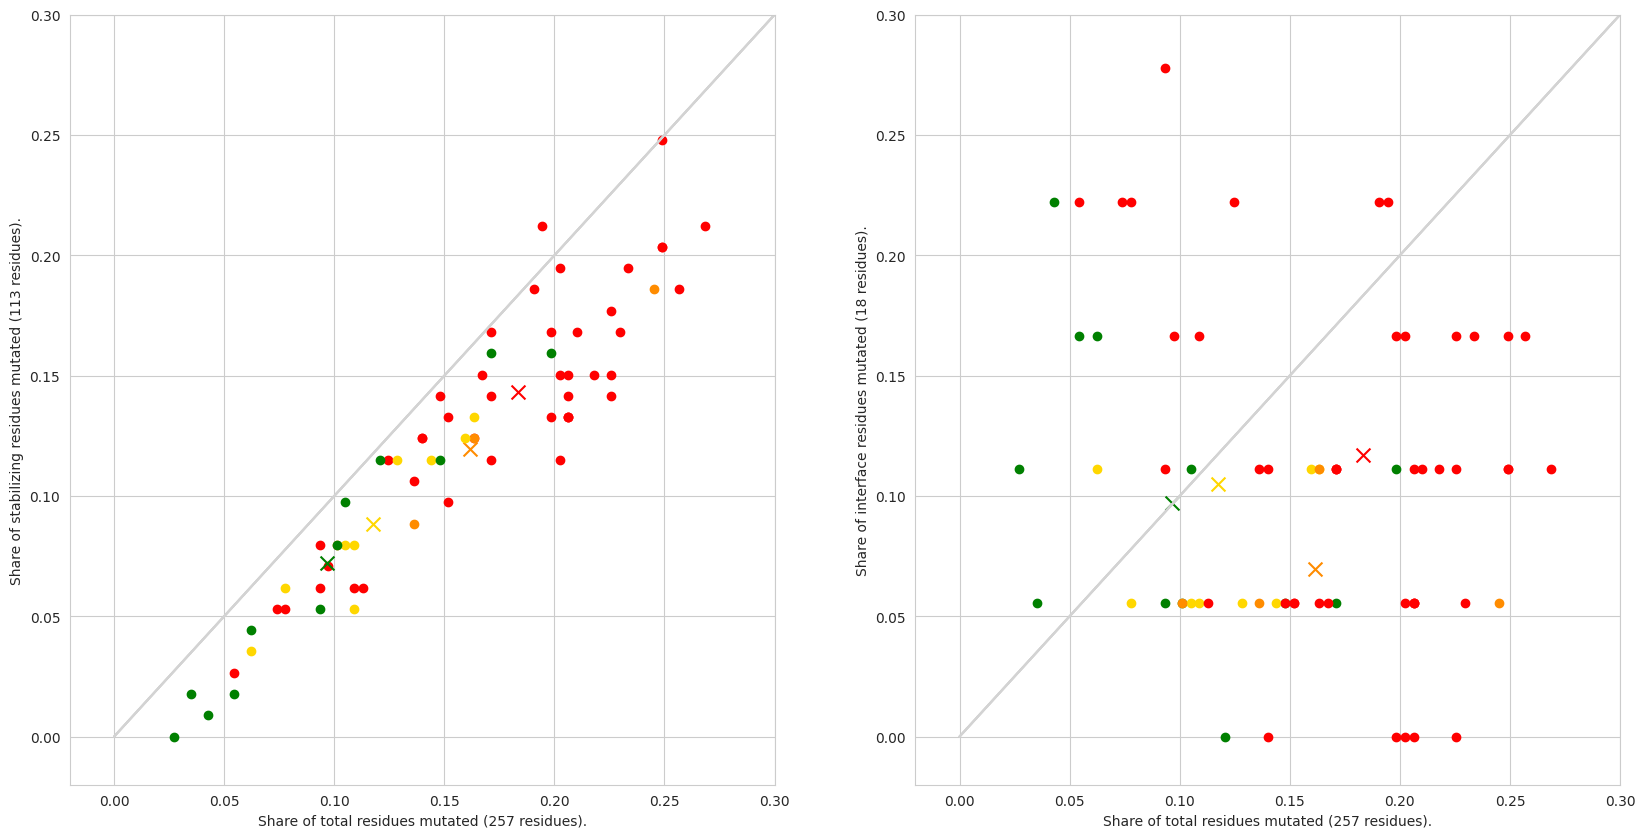

In [250]:
n = len(critical_for_stability_residues)
for x, c in zip(nb_mutations_at_stability_per_functionality[::-1], colors[:4][::-1]):
    plt.hist([x_/n for x_ in x], bins=np.arange(-.0, 1.05, 0.025), color=c)
    plt.xlabel(f"Share of stabilizing residues mutated ({n} residues).")
    plt.ylabel("Number of sequences")
    plt.xlim(0,0.2)
plt.show()

In [27]:

def run_command(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    if process.returncode != 0:
        raise RuntimeError(stderr.decode())

    return stdout.decode()

def generate_mutations_list(wild_type_seq, mutated_seq):
    mutations = []

    for i, (wt_residue, mutant_residue) in enumerate(zip(wild_type_seq, mutated_seq)):
        if wt_residue != mutant_residue:
            # FoldX format: originalResidue + position + mutatedResidue
            mutations.append(f"{wt_residue}A{i+1102}{mutant_residue}")

    return mutations

def run_foldx_build_model(i):
    try:
        # copy "in_complex.pdb" to "in_complex_i.pdb"
        copy_command = f"cp in_complex.pdb in_complex_{i}.pdb"
        run_command(copy_command)
        build_model_command = f"{FOLDX_PATH} --command=BuildModel --pdb=in_complex_{i}.pdb --mutant-file=individual_list_{i}.txt"
        run_command(build_model_command)
    except:
        failure.append(i)
    return i  # Return i just to track progress if needed


def extract_total_energy(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            # Check if the line starts with the PDB name
            if line.startswith("in_complex"):
                # Split the line by tabs and return the second value (index 1)
                return float(line.split('\t')[1])
    return None

def run_foldx_analyze_complex(i):
    build_model_command = f"{FOLDX_PATH} --command=AnalyseComplex --pdb=in_complex_{i}_1.pdb --analyseComplexChains=A,C,D --complexWithDNA=true"
    print(build_model_command)
    run_command(build_model_command)
    return i  # Return i just to track progress if needed

def get_interaction_energy(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("./in_complex"):
                return float(line.split()[-3])
    return None

In [ ]:
for i, seq in enumerate(sequences):
    mutations_list = generate_mutations_list(wt, seq)
    print(mutations_list)
    with open(f"individual_list_{i}.txt", "w") as f:
        for mutation in mutations_list:
            f.write(mutation + ",")

In [ ]:
analyse_complex_wt = f"{FOLDX_PATH} --command=AnalyseComplex --pdb=in_complex.pdb"

In [9]:
# Create a list of tasks
tasks = list(range(len(sequences)))
failure = []
with concurrent.futures.ProcessPoolExecutor(max_workers=40) as executor:
    for _ in tqdm_notebook(executor.map(run_foldx_build_model, tasks), total=len(tasks)):
        pass

with concurrent.futures.ProcessPoolExecutor(max_workers=40) as executor:
    for _ in tqdm_notebook(executor.map(run_foldx_analyze_complex, tasks), total=len(tasks)):
        pass

In [18]:
ddg = []
for i in range(len(sequences)):
    file_path = f"Dif_in_complex_{i}.fxout"
    total_energy = extract_total_energy(file_path)
    print(f"Total Energy for {file_path}: {total_energy}")
    ddg.append(total_energy)

Total Energy for Dif_in_complex_0.fxout: 9.59456
Total Energy for Dif_in_complex_1.fxout: 8.93058
Total Energy for Dif_in_complex_2.fxout: 2.31687
Total Energy for Dif_in_complex_3.fxout: 0.571959
Total Energy for Dif_in_complex_4.fxout: 8.17351
Total Energy for Dif_in_complex_5.fxout: 6.59631
Total Energy for Dif_in_complex_6.fxout: 3.79073
Total Energy for Dif_in_complex_7.fxout: 0.513096
Total Energy for Dif_in_complex_8.fxout: -3.81394
Total Energy for Dif_in_complex_9.fxout: 10.0703
Total Energy for Dif_in_complex_10.fxout: 2.61941
Total Energy for Dif_in_complex_11.fxout: 4.13852
Total Energy for Dif_in_complex_12.fxout: 5.67193
Total Energy for Dif_in_complex_13.fxout: 4.74835
Total Energy for Dif_in_complex_14.fxout: 3.54033
Total Energy for Dif_in_complex_15.fxout: 4.54588
Total Energy for Dif_in_complex_16.fxout: -1.47106
Total Energy for Dif_in_complex_17.fxout: 16.4838
Total Energy for Dif_in_complex_18.fxout: 8.88632
Total Energy for Dif_in_complex_19.fxout: 4.47143
Total 

In [15]:
wt_summary_filename = "Summary_in_complex_AC.fxout"
wt_interaction_energy = get_interaction_energy(wt_summary_filename)
interaction_energies_diff = []
for i in range(len(sequences)):
    filename = f"Summary_in_complex_{i}_1_AC.fxout"
    interaction_energy = get_interaction_energy(filename)
    interaction_energies_diff.append(interaction_energy - wt_interaction_energy)

In [2]:
plt.scatter(mcherry, interaction_energies_diff, c=functionality)
plt.xlabel("mCherry")
plt.ylabel("ddG")

plt.title(f"Interaction Energy vs mCherry (AUC : {roc_auc_score(np.where(mcherry>0.2,1,0), -np.array(ddg)):.3f}, Spearmanr: {scipy.stats.spearmanr(mcherry, -np.array(ddg))[0]:.3f})")
plt.show()


In [115]:
plt.scatter(ddg, interaction_energies_diff, c=functionality)
plt.xlabel("ddG")
plt.ylabel("Interaction Energy")

plt.title(f"ddG vs Interaction Energy (AUC : {roc_auc_score(np.where(mcherry>0.2,1,0), -np.array(ddg)):.3f}, Spearmanr: {scipy.stats.spearmanr(mcherry, -np.array(ddg))[0]:.3f})")
plt.show()


In [11]:
selected_gammas = sorted(gammas)[260:542]
collect_limits = [(190,193)]
X = []
for m, M in collect_limits:
    X.append(torch.cat([torch.cat(torch.load(f"{DATA}/vink/tracks/tracks_{selected_gammas[i]}.pt")[0],0) for i in range(m,M)], dim=0))

In [12]:
nnz_idx = torch.where(X[0][0].view(21,-1)[0] == 0)[0]
X = [x.reshape(x.size(0), 21,-1)[:, 1:, nnz_idx].argmax(1) for x in X]
seqs = [["".join([AA[i] for i in x__.int().numpy()]) for x__ in x_] for x_ in X]

all_seqs = []
for seq in seqs:
    all_seqs += seq

In [40]:
import subprocess


def run_command(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    if process.returncode != 0:
        raise RuntimeError(stderr.decode())

    return stdout.decode()


def generate_mutations_list(wild_type_seq, mutated_seq):
    mutations = []

    for i, (wt_residue, mutant_residue) in enumerate(zip(wild_type_seq, mutated_seq)):
        if wt_residue != mutant_residue:
            # FoldX format: originalResidue + position + mutatedResidue
            mutations.append(f"{wt_residue}A{i + 1102}{mutant_residue}")

    return mutations

# Define the function to be parallelized
def run_foldx(i):
    try:
        # copy "in_complex.pdb" to "in_complex_i.pdb"
        copy_command = f"cp in_complex.pdb in_complex_{i}.pdb"
        run_command(copy_command)
        build_model_command = f"{FOLDX_PATH} --command=BuildModel --pdb=in_complex_{i}.pdb --mutant-file=individual_list_{i}.txt"
        run_command(build_model_command)
    except:
        failure.append(i)
    return i  # Return i just to track progress if needed

def extract_total_energy(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            # Check if the line starts with the PDB name
            if line.startswith("in_complex"):
                # Split the line by tabs and return the second value (index 1)
                return float(line.split('\t')[1])
    return None


In [98]:
import concurrent
from tqdm.notebook import tqdm_notebook

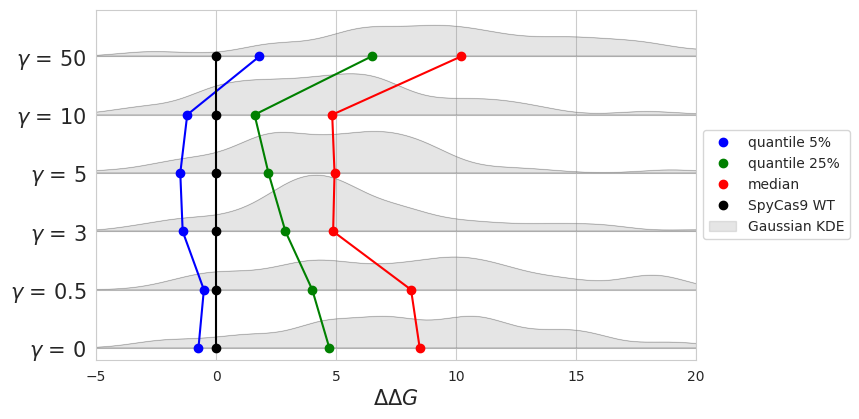

In [107]:
# We work by group of 128 sequences
batch_size = 480
nb_batches = 1
ddG2 = []
for i in range(nb_batches):
    sequences = all_seqs
    print("Batch", i, "/", nb_batches, "...")    
    # Generate mutations list
    for j, seq in enumerate(sequences):
        mutations_list = generate_mutations_list(wt, seq)
        with open(f"individual_list_{j}.txt", "w") as f:
            for mutation in mutations_list:
                f.write(mutation + ",")

    # Run FoldX
    # Create a list of tasks
    tasks = list(range(len(sequences)))

    # Parallelize using 32 processes
    failure = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=32) as executor:
        # Use tqdm for progress bar. The 'total' parameter ensures tqdm knows the total number of tasks.
        for _ in tqdm_notebook(executor.map(run_foldx, tasks), total=len(tasks)):
            pass

    # Extract ddG
    for j in range(len(sequences)):
        file_path = f"Dif_in_complex_{j}.fxout"
        total_energy = extract_total_energy(file_path)
        print(f"Total Energy for {file_path}: {total_energy}")
        ddG2.append(total_energy)

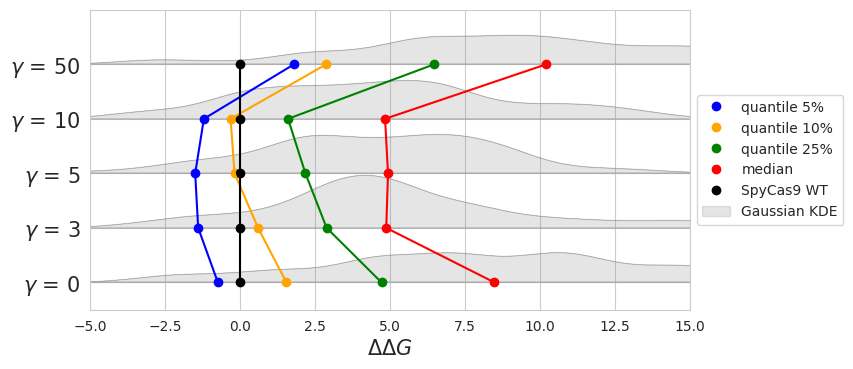

In [13]:
ddG = np.load(f"ddg.npy")
ddG2 = np.load(f"ddg2.npy")
collectn_1 = ddG[:96]
collectn_2 = ddG[96*2:96*3]
collectn_3 = ddG2
collectn_4 = ddG[96*3:96*4]
collectn_5 = ddG[96*4:]

## combine these different collections into a list
data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4, collectn_5]
quantile5 = [np.quantile(data, q=[0.05])[0] for data in data_to_plot]
quantile10 = [np.quantile(data, q=[0.1])[0] for data in data_to_plot]
quantile25 = [np.quantile(data, q=[0.25])[0] for data in data_to_plot]
med = [np.median(data) for data in data_to_plot]

# Create a figure instance
fig = plt.figure(figsize=(6, 3))

# Create an axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Create the boxplot
colors = ["blue", "orange", "green", "red"]

for i, data in enumerate(data_to_plot):
    kde = KernelDensity(kernel='gaussian', bandwidth=1.2).fit(data[:, None])

    # Create a range of x-values to evaluate the KDE model on
    x_vals = np.linspace(-10, 30, 500).reshape(-1, 1)

    # Evaluate the KDE model on the x-values
    log_dens = kde.score_samples(x_vals)
    dens = np.exp(log_dens) * 8
    ax.plot(x_vals, dens + i + 1, color='gray', linewidth=0.3)

    ax.plot(x_vals, [i + 1 for _ in x_vals], color='gray', linewidth=0.3)
    if i == 0:
        ax.fill_between(x_vals[:, 0], i + 1, dens + i + 1, color='gray', alpha=0.2, label="Gaussian KDE")
    else:
        ax.fill_between(x_vals[:, 0], i + 1, dens + i + 1, color='gray', alpha=0.2)

ax.plot(quantile5, [1, 2, 3, 4, 5], 'o', color=colors[0], label="quantile 5%")
ax.plot(quantile10, [1, 2, 3, 4, 5], 'o', color=colors[1], label="quantile 10%")
ax.plot(quantile25, [1, 2, 3, 4, 5], 'o', color=colors[2], label="quantile 25%")
ax.plot(med, [1, 2, 3, 4, 5], 'o', color=colors[3], label="median")
ax.plot([0,0,0,0,0], [1, 2, 3, 4, 5], 'o', color="black", label="SpyCas9 WT")
ax.plot(quantile5, [1, 2, 3, 4, 5], color=colors[0])
ax.plot(quantile10, [1, 2, 3, 4, 5], color=colors[1])
ax.plot(quantile25, [1, 2, 3, 4, 5], color=colors[2])
ax.plot(med, [1, 2, 3, 4, 5], color=colors[3])
ax.plot([0,0,0,0,0], [1, 2, 3, 4, 5], color="black")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.yticks([1, 2, 3, 4, 5], ["$\gamma$ = 0", "$\gamma$ = 3", "$\gamma$ = 5", "$\gamma$ = 10", "$\gamma$ = 50"],
           fontsize=15)
plt.xlim(-5, 15)
plt.ylim(0.5, 6)
plt.xlabel("$\Delta\Delta G$", fontsize=15)
plt.show()


In [19]:
from random import shuffle

df = pd.read_excel(f"{DATA}/ML-designed PID.xlsx")

wt = df[df.batch == 0].iloc[0].seq

X2 = torch.load("seq_gen_diverse_length_and_seq.pt")
idx = list(range(len(X2)))
shuffle(idx)
idx = np.array(sorted(idx[:500]))
X2 = torch.tensor(X2[idx])

In [20]:
X2 = [x[nnz_idx]-1 for x in X2]
sequences= ["".join([AA[i] for i in seq.numpy()]) for seq in X2]


In [35]:

X2 = [x[nnz_idx]-1 for x in X2]
sequences= ["".join([AA[i] for i in seq.numpy()]) for seq in X2]
n_muts = []
for j, seq in enumerate(sequences):
    mutations_list = generate_mutations_list(wt, seq)
    n_muts.append(len(mutations_list))
    with open(f"individual_list_{j}.txt", "w") as f:
        for mutation in mutations_list:
            f.write(mutation + ",")

IndexError: index 260 is out of bounds for dimension 0 with size 257

In [252]:
# Run FoldX
# Create a list of tasks
tasks = list(range(len(sequences)))

# Parallelize using 32 processes
failure = []
with concurrent.futures.ProcessPoolExecutor(max_workers=32) as executor:
    # Use tqdm for progress bar. The 'total' parameter ensures tqdm knows the total number of tasks.
    for _ in tqdm_notebook(executor.map(run_foldx, tasks), total=len(tasks)):
        pass


In [176]:
ddG3 = []
# Extract ddG
for j in range(len(sequences)):
    file_path = f"Dif_in_complex_{j}.fxout"
    total_energy = extract_total_energy(file_path)
    print(f"Total Energy for {file_path}: {total_energy}")
    ddG3.append(total_energy)

Total Energy for Dif_in_complex_0.fxout: 0.34694
Total Energy for Dif_in_complex_1.fxout: 0.909854
Total Energy for Dif_in_complex_2.fxout: 0.324117
Total Energy for Dif_in_complex_3.fxout: -2.23958
Total Energy for Dif_in_complex_4.fxout: 2.80899
Total Energy for Dif_in_complex_5.fxout: -1.16421
Total Energy for Dif_in_complex_6.fxout: -2.53269
Total Energy for Dif_in_complex_7.fxout: 0.663655
Total Energy for Dif_in_complex_8.fxout: -5.27197
Total Energy for Dif_in_complex_9.fxout: -4.23991
Total Energy for Dif_in_complex_10.fxout: 4.43783
Total Energy for Dif_in_complex_11.fxout: 3.31566
Total Energy for Dif_in_complex_12.fxout: 2.13629
Total Energy for Dif_in_complex_13.fxout: 6.9718
Total Energy for Dif_in_complex_14.fxout: 3.91945
Total Energy for Dif_in_complex_15.fxout: 2.5924
Total Energy for Dif_in_complex_16.fxout: 2.31004
Total Energy for Dif_in_complex_17.fxout: 3.41867
Total Energy for Dif_in_complex_18.fxout: 1.42872
Total Energy for Dif_in_complex_19.fxout: 7.17188
Tota

In [5]:
import torch

In [71]:
from copy import deepcopy

sequences = []
n_muts = []
for j in range(500):
    muts = []
    sequence = deepcopy(wt)
    n_muts_ = 0
    with open(f"individual_list_{j}.txt", "r") as f:
        lines = f.readlines()
        for line in lines:
            muts = line.split(",")[:-1]
            break
        for mut in muts:
            pos = int(mut[2:6])-1102
            aa = mut[6]
            print(mut, pos, aa)
            sequence = sequence[:pos] + aa + sequence[pos+1:]
            n_muts_ += 1
    sequences.append(sequence)
    n_muts.append(n_muts_)
X2 = torch.tensor([[AA_IDS[x] for x in seq] for seq in sequences])
X_unlabelled = torch.zeros(len(X2), 21, 736)
X_unlabelled[:, 0] = 1
X_unlabelled[:, :, nnz_idx] = 0
for i in range(len(X2)):
    X_unlabelled[i, X2[i] + 1, nnz_idx] = 1


NA1115D 13 D
AA1121P 19 P
KA1124T 22 T
SA1154A 52 A
LA1164V 62 V
EA1189R 87 R
KA1191R 89 R
MA1213L 111 L
LA1257E 155 E
QA1272L 170 L
SA1292E 190 E
QA1305L 203 L
FA1313L 211 L
LA1315F 213 F
YA1326F 224 F
DA1125N 23 N
KA1148D 46 D
NA1177D 75 D
KA1191R 89 R
KA1211R 109 R
EA1268D 166 D
LA1291N 189 N
KA1296Q 194 Q
IA1309F 207 F
LA1315F 213 F
TA1316V 214 V
KA1124T 22 T
DA1125Y 23 Y
EA1189R 87 R
KA1191R 89 R
LA1194M 92 M
KA1197I 95 I
LA1226I 124 I
KA1244S 142 S
EA1260D 158 D
QA1272L 170 L
QA1305L 203 L
LA1315F 213 F
DA1344N 242 N
DA1125Y 23 Y
EA1189R 87 R
KA1191R 89 R
LA1194M 92 M
KA1197I 95 I
EA1268D 166 D
QA1272L 170 L
QA1305L 203 L
EA1307N 205 N
KA1325E 223 E
KA1124T 22 T
EA1189R 87 R
KA1191R 89 R
LA1194M 92 M
KA1197I 95 I
KA1211R 109 R
EA1253H 151 H
EA1268D 166 D
AA1293L 191 L
EA1307N 205 N
LA1315F 213 F
TA1316N 214 N
RA1114G 12 G
DA1125Y 23 Y
KA1129R 27 R
KA1148D 46 D
EA1189Q 87 Q
KA1191E 89 E
QA1272L 170 L
IA1302V 200 V
QA1305L 203 L
IA1309F 207 F
YA1326F 224 F
AA1345S 243 S
KA1124T 22 

In [61]:
from torchpgm import OneHotLayer, GaussianLayer, PAM_classifier, PI_RBM_SSL, RBMDataWithPAM

Npam = 5
Nh = 200
folder = f"{DATA}/vink"
model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}_gamma5.306595410288844"
best_epoch = 90

train_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "train_labelled")

q_pi, N_pi = train_dataset_labelled[0][0].size()

pi = OneHotLayer(None, N=N_pi, q=q_pi, name="pi")
h = GaussianLayer(N=Nh, name="hidden")
classifier = PAM_classifier(Nh, Npam * 4, dropout = 0.)
E = [(pi.name, h.name)]
E.sort()

model_rbm_ssl = PI_RBM_SSL(classifier, layers= {pi.name: pi, h.name: h}, edges=E, name = "")
model_rbm_ssl.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")
model_rbm_ssl = model_rbm_ssl.to("cpu")
model_rbm_ssl.ais()

Available :  pi_seq L labelled subset weights x y


/home/malbrank/Documents/cas9/torchpgm/edge.py:131: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.linear.weight)


3.29761004447937

In [73]:
with torch.no_grad():
    e_rbm_unlabelled = -(model_rbm_ssl({"pi":X_unlabelled.cpu()})/736 - model_rbm_ssl.Z).cpu().detach().numpy()
#ddG_unlabelled = ddG3

In [55]:
def mcherry_threshold(x):
    if x < 0.2:
        return 0
    if x < 0.5:
        return 1
    if x < 0.8:
        return 2
    return 3

colors = ["red","darkorange","gold","green", "gray", "gray"]
functionality = df[(df.batch  == 0) | (df.batch  >= batch)]["mcherry"].apply(lambda x:colors[mcherry_threshold(x)]).values
functionality_number = df[(df.batch  == 0) | (df.batch  >= batch)]["mcherry"].apply(lambda x:mcherry_threshold(x)).values

In [23]:
batch = 2
df = pd.read_excel(f"{DATA}/ML-designed PID.xlsx")
ddg_labelled = df[(df.batch  == 0) | (df.batch  >= batch)]["ddg"].apply(lambda x : float(x)).values
X_labelled = []
for seq in df.seq[(df.batch  == 0) | (df.batch  >= batch)]:
    seq_onehot = torch.tensor(to_onehot([AA_IDS[x__]+1 if x__ in AA else 0 for x__ in seq],(None,21)).T)
    x_ = torch.zeros(21,736)
    x_[0,zero_idx] = 1
    x_[:,nnz_idx] = seq_onehot.float()
    X_labelled.append(x_)
X_labelled = torch.stack(X_labelled,0)
with torch.no_grad():
    e_rbm_labelled = -(model_rbm_ssl({"pi":X_labelled.cuda()})/736 - model_rbm_ssl.Z).cpu().detach().numpy()

In [24]:
plt.figure(figsize = (5,5))
plt.scatter(ddG_unlabelled, e_rbm_unlabelled, color = "lightgray",s=2, marker = "s")
plt.scatter([], [], color="gray", marker = "^")
plt.scatter([], [], color="gray")
plt.scatter(ddg_labelled[0], e_rbm_labelled[0], marker="+", color = "black", s = 160)

filt = (df[df.batch  >= batch].batch == 2).values
plt.scatter(ddg_labelled[1:][filt], e_rbm_labelled[1:][filt], color=functionality[1:][filt], marker = "^")
filt = (df[df.batch  >= batch].batch == 3).values
plt.scatter(ddg_labelled[1:][filt], e_rbm_labelled[1:][filt], color=functionality[1:][filt])

# plt.plot([0,200],y, c="black")
plt.scatter([0], ddg_labelled[:1], marker="+", color = "black", s = 160)
# plt.title(f"Spearman = {spearmanr(normfl,labelled_ebrbm)[0]:.3f}")
plt.xlim(63,135)
plt.ylim(-0.21, -0.07)
plt.ylim(-.235,-.10)
plt.xlim(-5,30)
plt.xlabel("$\Delta\Delta\mathrm{G}$", fontsize=15)
plt.ylabel("$E_{\mathrm{RBM}}$", fontsize=15)
plt.legend(['Untested', "Batch 1", "Batch 2","SpyCas9 WT"])


NameError: name 'ddG_unlabelled' is not defined

<Figure size 500x500 with 0 Axes>

In [60]:
e_rbm_unlabelled

array([-3.523913 , -3.5257678, -3.5273495, -3.52779  , -3.5273495,
       -3.5270352, -3.5273495, -3.52779  , -3.5273495, -3.5272036,
       -3.5257678, -3.5273495, -3.5235956, -3.5235798, -3.5235798,
       -3.5233781, -3.5267425, -3.5245378, -3.5245378, -3.5223916,
       -3.523913 , -3.5231848, -3.5264323, -3.5235956, -3.5245378,
       -3.5223567, -3.523913 , -3.5213742, -3.5245378, -3.5223656,
       -3.5232077, -3.5223916, -3.5264323, -3.522827 , -3.5231848,
       -3.5232077, -3.5231848, -3.5223656, -3.522827 , -3.522827 ,
       -3.5241594, -3.5194325, -3.519449 , -3.5223656, -3.522827 ,
       -3.521836 , -3.5235798, -3.511298 , -3.519449 , -3.5235906,
       -3.511298 , -3.511298 , -3.5236566, -3.5217392, -3.5243723,
       -3.522827 , -3.524865 , -3.5194325, -3.522827 , -3.5270352,
       -3.52779  , -3.523913 , -3.5245378, -3.5235798, -3.5273495,
       -3.5270352, -3.5273495, -3.5273495, -3.5245378, -3.52779  ,
       -3.52779  , -3.5264323, -3.5273495, -3.5239832, -3.5245

In [75]:
dist_unlabelled = n_muts
dist_labelled = (df[(df.batch  == 0) | (df.batch  >= batch)]["sim_cas9"]).values

In [57]:
len(dist_unlabelled), len(e_rbm_unlabelled)

(500, 500)

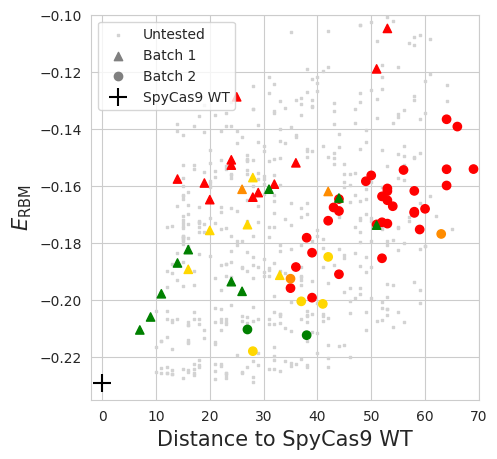

In [77]:
plt.figure(figsize = (5,5))
plt.scatter(dist_unlabelled, e_rbm_unlabelled, color = "lightgray",s=2, marker = "s")
plt.scatter([], [], color="gray", marker = "^")
plt.scatter([], [], color="gray")
plt.scatter(dist_labelled[0], e_rbm_labelled[0], marker="+", color = "black", s = 160)

filt = (df[df.batch  >= batch].batch == 3).values
plt.scatter(dist_labelled[1:][filt], e_rbm_labelled[1:][filt], color=functionality[1:][filt])
filt = (df[df.batch  >= batch].batch == 2).values
plt.scatter(dist_labelled[1:][filt], e_rbm_labelled[1:][filt], color=functionality[1:][filt], marker = "^")

# plt.plot([0,200],y, c="black")
plt.scatter([0], dist_labelled[:1], marker="+", color = "black", s = 160)
# plt.title(f"Spearman = {spearmanr(normfl,labelled_ebrbm)[0]:.3f}")
plt.xlim(63,135)
plt.ylim(-0.21, -0.07)
plt.ylim(-.235,-.10)
plt.xlim(-2,70)
plt.xlabel("Distance to SpyCas9 WT", fontsize=15)
plt.ylabel("$E_{\mathrm{RBM}}$", fontsize=15)
plt.legend(['Untested', "Batch 1", "Batch 2","SpyCas9 WT"])
